In [ ]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.preprocessing import MultiLabelBinarizer
import re

In [ ]:
movie_details_fpath = "../../../../IMDB_movie_details.json"
reviews_fpath = "../../../../IMDB_reviews.json"

In [ ]:
movie_details_list = []
with open(movie_details_fpath, 'r') as file:
  for line in file:
    movie_details_list.append(json.loads(line))

reviews_path_list = []
with open(reviews_fpath, 'r') as file:
  for line in file:
    reviews_path_list.append(json.loads(line))
    
movie_details = pd.DataFrame(movie_details_list, columns = ['movie_id', 'plot_summary', 'duration', 'genre', 'rating', 'release_date', 'plot_synopsis'])
reviews = pd.DataFrame(reviews_path_list, columns = ['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text', 'rating', 'review_summary'])

In [66]:
movie_details.rename(columns={'rating': 'movie_rating'}, inplace=True)
reviews.rename(columns={'rating': 'personal_rating'}, inplace=True)

imdb = pd.merge(movie_details, reviews, on='movie_id')
imdb.head(5)

,movie_id,plot_summary,duration,genre,movie_rating,release_date,plot_synopsis,review_date,user_id,is_spoiler,review_text,personal_rating,review_summary
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",5 March 2008,ur16517420,True,The second Tom Clancy novel made into a film (...,6,decent Clancy thriller
1,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",15 October 2007,ur13887584,True,The second in what looks like becoming the 'Ja...,7,Jack Ryan Chapter II
2,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",16 September 2013,ur2403537,True,I was not a fan of The Hunt For Red October. I...,8,It's filled to the brim with excitement and it...
3,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",15 May 2007,ur0819382,True,Jack Ryan (Harrison Ford) is a CIA analyst who...,7,Patriotic Gore.
4,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in...",29 February 2004,ur2567338,True,This was one of the big summer movies of 1992....,7,Harrison Ford In Another Tom Clancy Adaptation


## Features

### Numerical Features

In [67]:
imdb["movie_rating"]    = pd.to_numeric(imdb["movie_rating"])
imdb["personal_rating"] = pd.to_numeric(imdb["personal_rating"])
imdb["is_spoiler"] = imdb["is_spoiler"].astype(str).map({"True":1, "False":0})


### Categorical Features

In [78]:
def parse_duration(x):
    s = str(x).lower().strip()
    if re.fullmatch(r"\d+", s):
        return int(s)
    h = re.search(r'(\d+)\s*h', s)
    m = re.search(r'(\d+)\s*min', s)
    hh = int(h.group(1)) if h else 0
    mm = int(m.group(1)) if m else 0
    if h and not m:
        return hh * 60
    if m and not h:
        return mm
    if h or m:
        return hh * 60 + mm
    return np.nan

def normalize_ymd(s):
    s = str(s).strip()
    if re.fullmatch(r"\d{4}", s):                 # "1991" -> "1991-01-01"
        return f"{s}-01-01"
    if re.fullmatch(r"\d{4}-\d{2}", s):           # "1991-03" -> "1991-03-01"
        return f"{s}-01"
    return s   

def to_list_genre(x):
    s = str(x).strip().strip('[]')
    if not s: return []
    return [p.strip().strip("'\"") for p in s.split(',') if p.strip()]

def freq_encode(series):
    vc = series.value_counts(dropna=False)
    return series.map(vc).astype(float)

def normalize_year_only(s):
    s = str(s).strip()
    return f"{s}-01-01" if re.fullmatch(r"\d{4}", s) else s

In [128]:
imdb['release_date_norm'] = imdb['release_date'].map(normalize_ymd)
imdb['review_date_norm']  = imdb['review_date'].map(normalize_ymd)

imdb['release_date_dt'] = pd.to_datetime(imdb['release_date_norm'], format='mixed')
imdb['review_date_dt']  = pd.to_datetime(imdb['review_date_norm'],  format='mixed')

imdb['release_year']   = imdb['release_date_dt'].dt.year
imdb['release_month']  = imdb['release_date_dt'].dt.month
imdb['review_year']    = imdb['review_date_dt'].dt.year
imdb['review_month']   = imdb['review_date_dt'].dt.month
imdb['days_to_review'] = (imdb['review_date_dt'] - imdb['release_date_dt']).dt.days

imdb['movie_id_freq'] = freq_encode(imdb['movie_id'])
imdb['user_id_freq']  = freq_encode(imdb['user_id'])

In [80]:
# multi-label encode genre
g_lists = imdb['genre'].apply(to_list_genre)
mlb = MultiLabelBinarizer()
G = pd.DataFrame(
    mlb.fit_transform(g_lists),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=imdb.index
)
imdb = pd.concat([imdb, G], axis=1)

### Transformed Features

In [81]:
imdb["review_text"] = imdb["review_text"].fillna("")
imdb["review_word_length"] = imdb["review_text"].str.split().apply(len)
imdb["review_chars_length"] = imdb["review_text"].str.len()
imdb["num_exclaimation_marks"] = imdb["review_text"].str.count("!")
imdb["num_question_marks"] = imdb["review_text"].str.count(r"\?")

In [82]:
imdb["polarity"] = imdb["review_text"].apply(lambda s: TextBlob(s).sentiment.polarity)
imdb["subjectivity"] = imdb["review_text"].apply(lambda s: TextBlob(s).sentiment.subjectivity)

## Correlation Heatmap

In [90]:
corr_features = [
    "release_year","release_month","review_year","review_month","days_to_review",
    "movie_id_freq","user_id_freq","review_word_length","review_chars_length",
    "num_exclaimation_marks","num_question_marks","polarity","subjectivity"
]

In [91]:
genre_features = [c for c in imdb.columns if c.startswith("genre_")]
target_column = ["is_spoiler"] if "is_spoiler" in imdb.columns else []
feature_list = [c for c in corr_features + genre_features + target_column if c in imdb.columns]

In [92]:
corr_data = imdb[feature_list].select_dtypes(include="number").copy()
corr_data = corr_data.dropna(axis=1, how="all")
corr_data = corr_data.loc[:, corr_data.nunique(dropna=True) > 1]
corr = corr_data.corr()

<Axes: >

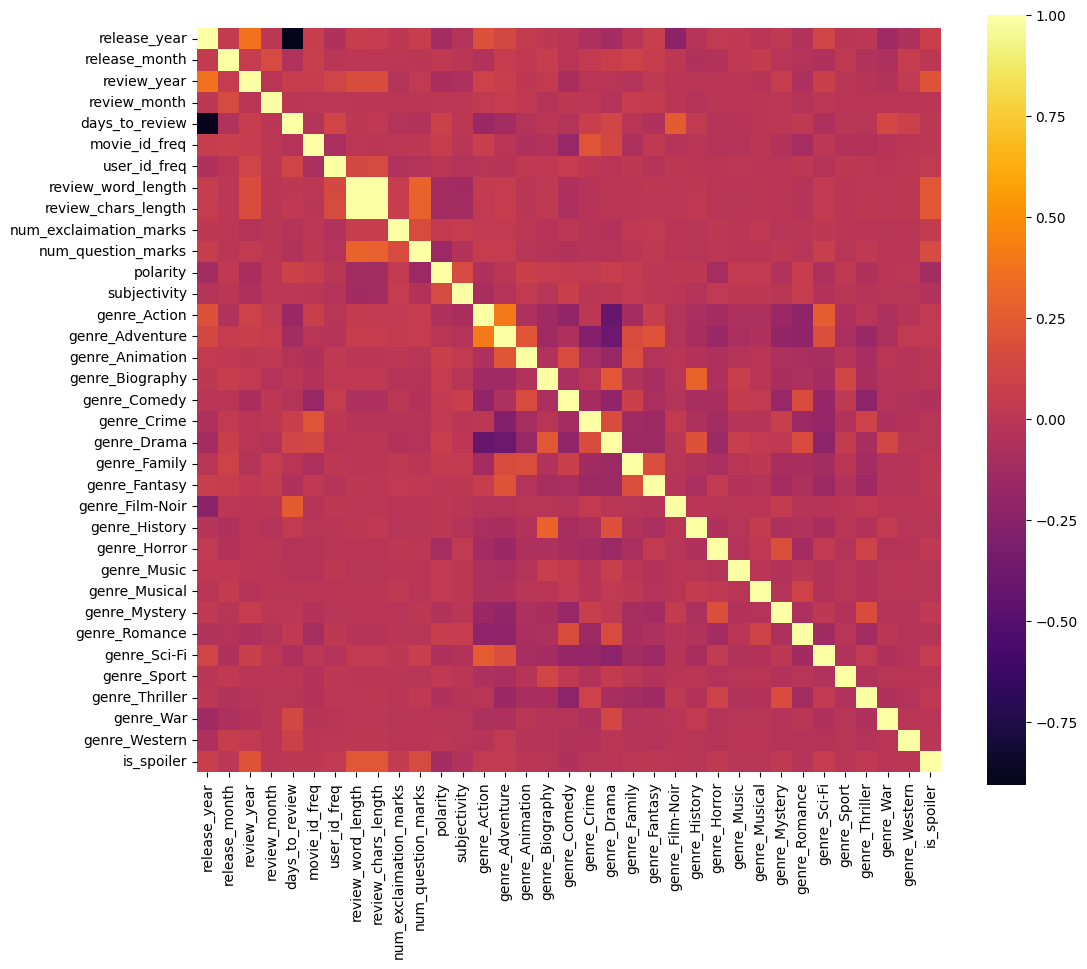

In [95]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="inferno", center=0, square=True)

## Histogram

In [96]:
histo_features = [
    "review_word_length", "review_chars_length",
    "num_exclaimation_marks", "num_question_marks",
    "polarity", "subjectivity", "days_to_review"
]

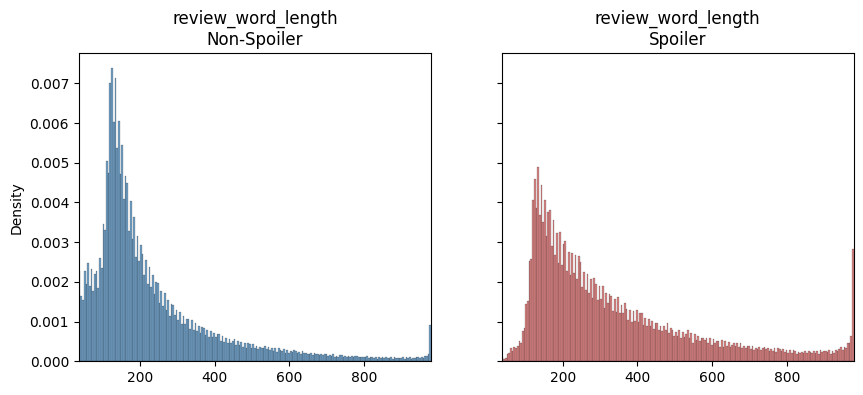

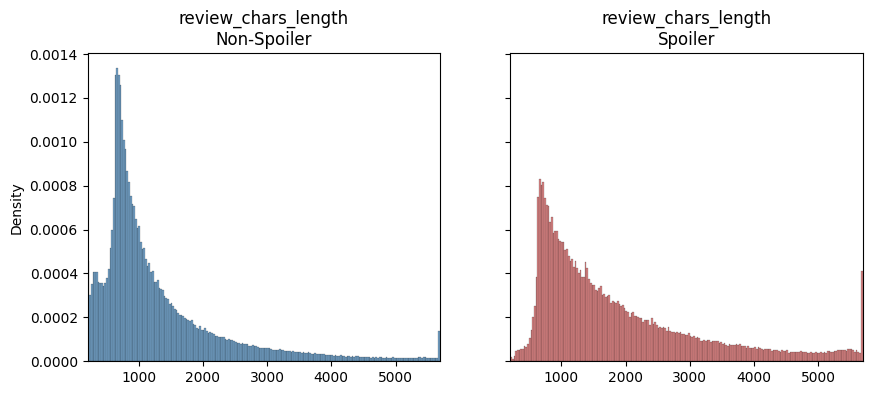

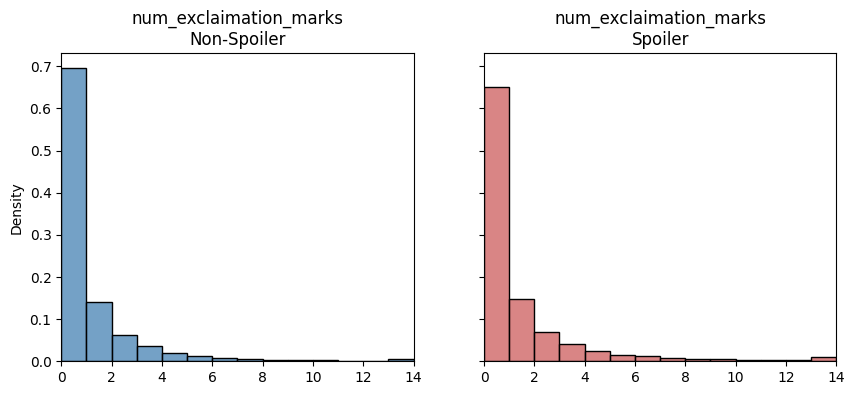

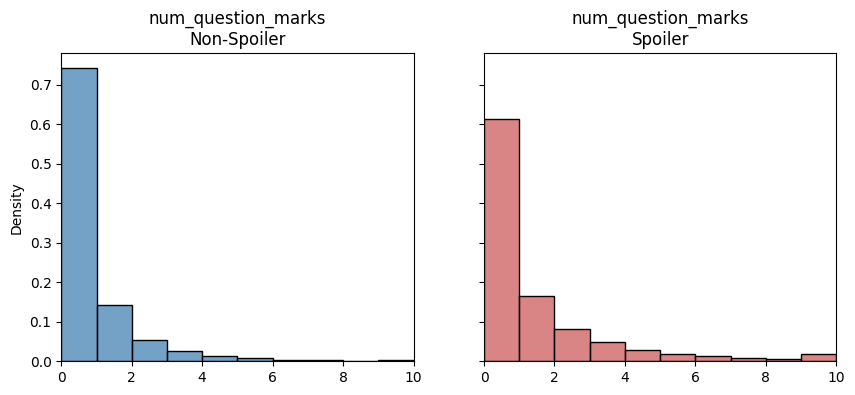

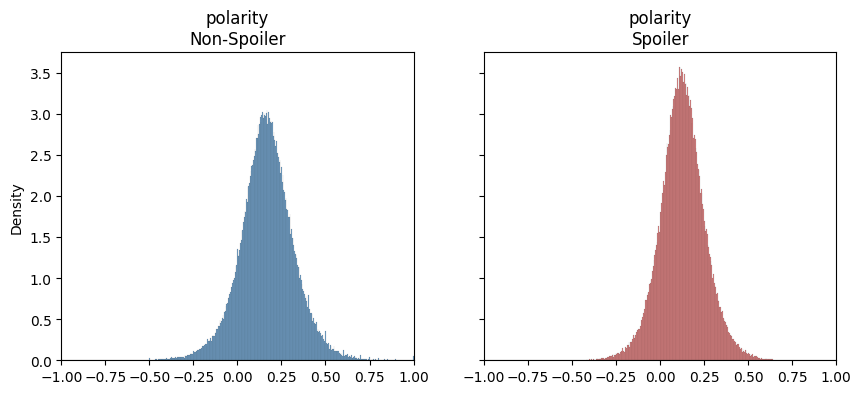

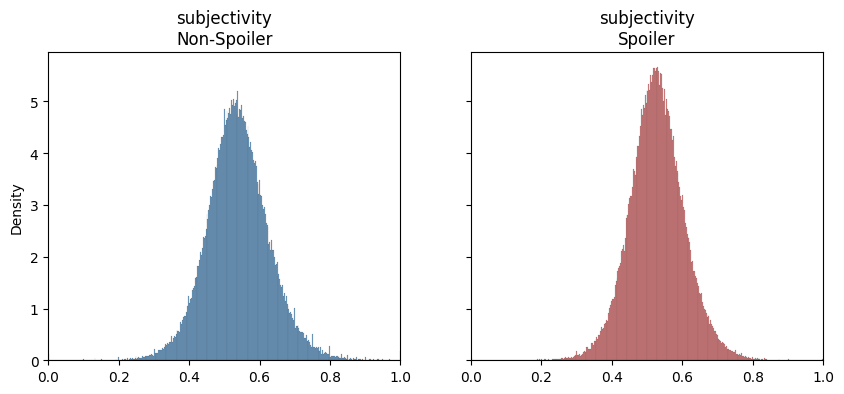

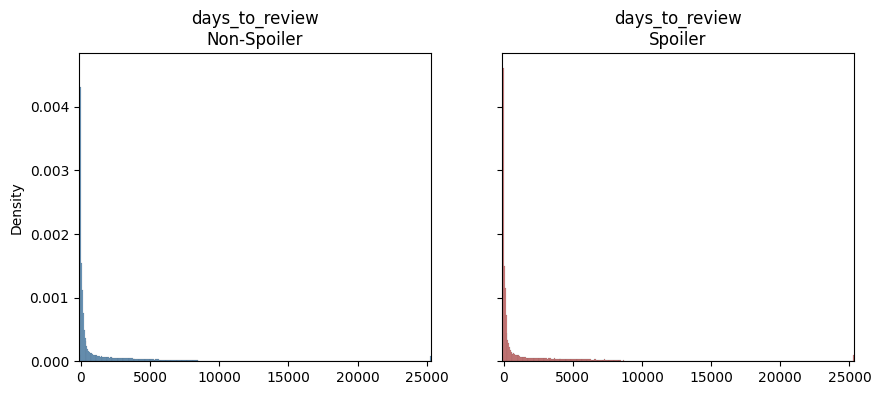

In [99]:
for f in histo_features:
    x0 = imdb.loc[imdb["is_spoiler"]==0, f].dropna()
    x1 = imdb.loc[imdb["is_spoiler"]==1, f].dropna()
    allx = pd.concat([x0, x1])

    if f == "polarity": lo, hi = -1.0, 1.0
    elif f == "subjectivity": lo, hi = 0.0, 1.0
    else:
        lo, hi = np.nanpercentile(allx, [0.5, 99.5])
        if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
            lo, hi = allx.min(), allx.max()

    x0 = x0.clip(lo, hi); x1 = x1.clip(lo, hi)
    bins = np.histogram_bin_edges(pd.concat([x0, x1]), bins="auto")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    sns.histplot(x=x0, bins=bins, stat="density", ax=ax[0], color = "steelblue")
    sns.histplot(x=x1, bins=bins, stat="density", ax=ax[1], color = "indianred")
    for a, t in zip(ax, ["Non-Spoiler","Spoiler"]):
        a.set_xlim(lo, hi); a.set_title(f"{f}\n{t}"); a.set_xlabel(""); a.set_ylabel("Density")

## Genre Proportion

In [108]:
# Compare the mean proportion of each genre between spoiler and non-spoiler reviews instead of using raw counts, 
# since the dataset sizes are unequal.
imdb["is_spoiler"].value_counts(normalize=True) * 100

is_spoiler
0    73.702314
1    26.297686
Name: proportion, dtype: float64

In [121]:
genre_cols = [c for c in imdb.columns if c.startswith("genre_")]

In [122]:
genre_counts = imdb[genre_cols].sum().sort_values(ascending=False)
genre_sorted = imdb[genre_cols].sum().sort_values(ascending=False).index.tolist()

Text(0.5, 0, 'Count')

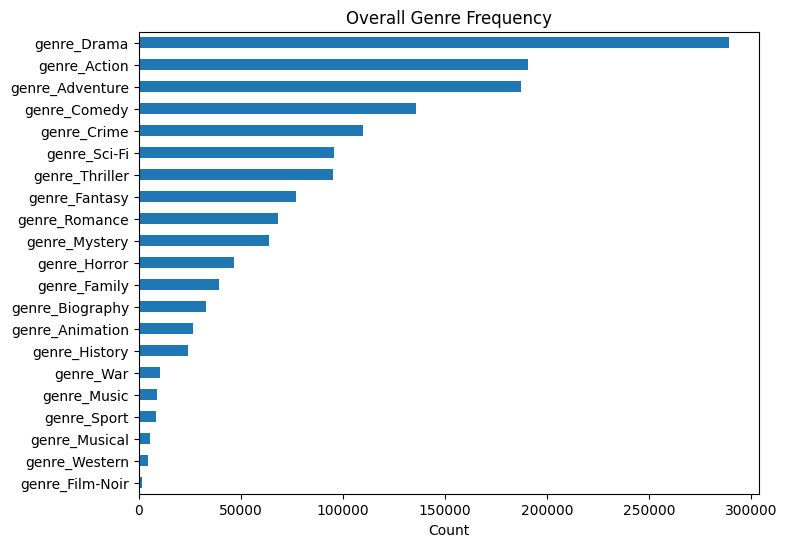

In [123]:
genre_counts.plot(kind="barh", figsize=(8,6))
plt.title("Overall Genre Frequency")
plt.gca().invert_yaxis()
plt.xlabel("Count")

In [124]:
proportion = (
    imdb.groupby("is_spoiler")[genre_sorted].mean().T
      .rename(columns={0:"Non-Spoiler",1:"Spoiler",False:"Non-Spoiler",True:"Spoiler"})
)

proportion.index = (
    pd.Index(proportion.index)
      .str.replace(r"^genre_", "", regex=True)
      .str.replace("_", " ")
      .str.title()
)

Text(0.5, 0, 'Proportion')

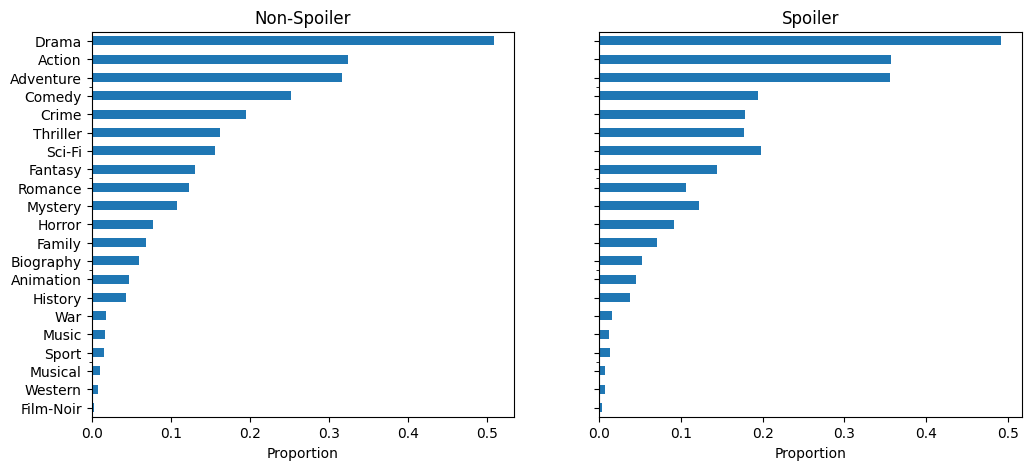

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
proportion["Non-Spoiler"].sort_values(ascending=True).plot(kind="barh", ax=ax[0])
proportion["Spoiler"].loc[proportion["Non-Spoiler"].sort_values().index].plot(kind="barh", ax=ax[1])
ax[0].set_title("Non-Spoiler")
ax[1].set_title("Spoiler")
ax[0].set_xlabel("Proportion")
ax[1].set_xlabel("Proportion")

## Spoiler Rate Over Time

In [136]:
time_data = imdb.loc[imdb["is_spoiler"].notna(), ["review_year","days_to_review","is_spoiler"]].copy()

In [137]:
year_rate = time_data.groupby("review_year")["is_spoiler"].mean().dropna()

In [139]:
bins = pd.cut(time_data["days_to_review"], bins=30)
days_rate = time_data.groupby(bins)["is_spoiler"].mean()
x_mid = pd.Series([(b.left + b.right)/2 for b in days_rate.index], index=days_rate.index)

/var/folders/qw/0q1k53t510l2k5m76b5xnqp40000gn/T/ipykernel_10702/3991763731.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  days_rate = time_data.groupby(bins)["is_spoiler"].mean()


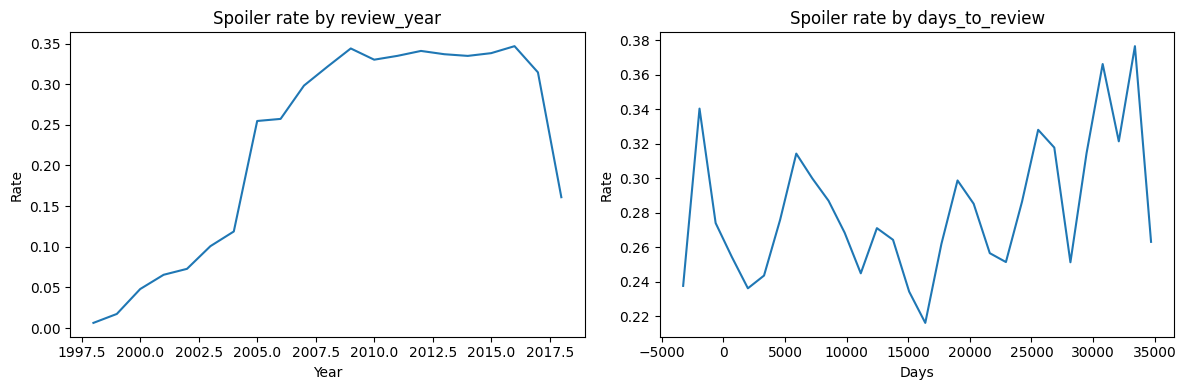

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x=year_rate.index, y=year_rate.values, ax=ax[0])
sns.lineplot(x=x_mid.values, y=days_rate.values, ax=ax[1])
ax[0].set_title("Spoiler rate by review_year"); ax[0].set_xlabel("Year"); ax[0].set_ylabel("Rate")
ax[1].set_title("Spoiler rate by days_to_review"); ax[1].set_xlabel("Days"); ax[1].set_ylabel("Rate")
plt.tight_layout(); plt.show()